In [1]:
import warnings
warnings.filterwarnings('ignore')

from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.models.efficientnet import *

In [2]:
data_path = Path('./chest_xray').absolute()
model_path = Path('./model').absolute()

In [3]:
stats = ([0.48746821, 0.48746821, 0.48746821], [0.24557937, 0.24557937, 0.24557937])

def valid_func(o):
    return 'test' in str(o)

def label_func(o):
    name = o.name
    if 'virus' in name:
        return 'virus'
    if 'bacteria' in name:
        return 'bacteria'
    return 'normal'

data = (ImageList.from_folder(data_path)
        .split_by_valid_func(valid_func)
        .label_from_func(label_func)
        .transform(get_transforms(), size=456)
        .databunch()
        .normalize(stats)
        )

data, data.classes

(ImageDataBunch;
 
 Train: LabelList (5232 items)
 x: ImageList
 Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
 y: CategoryList
 normal,normal,normal,normal,normal
 Path: /media/sm2/data/pneumonia/chest_xray;
 
 Valid: LabelList (624 items)
 x: ImageList
 Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
 y: CategoryList
 normal,normal,normal,normal,normal
 Path: /media/sm2/data/pneumonia/chest_xray;
 
 Test: None,
 ['bacteria', 'normal', 'virus'])

In [4]:
model = EfficientNet.from_pretrained('efficientnet-b5')
model

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /home/sm2/.cache/torch/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [5]:
model._fc = nn.Linear(2048, 3)

In [6]:
learn = Learner(data, 
                model,
                bn_wd=False,
                metrics=error_rate,
                loss_func=LabelSmoothingCrossEntropy(),
                callback_fns=[BnFreeze,
                              partial(SaveModelCallback, monitor='error_rate', name='best_error')
                             ],
               ).to_fp16()

In [7]:
learn.split(lambda m: (model._conv_head,))
learn.freeze()

learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.770701,0.993387,0.403846,02:09
1,0.694102,0.996868,0.383013,02:06
2,0.659895,0.752850,0.238782,02:07
3,0.629323,0.716492,0.230769,02:07
4,0.604657,0.703950,0.222756,02:06


Better model found at epoch 0 with error_rate value: 0.4038461446762085.
Better model found at epoch 1 with error_rate value: 0.3830128312110901.
Better model found at epoch 2 with error_rate value: 0.23878204822540283.
Better model found at epoch 3 with error_rate value: 0.23076923191547394.
Better model found at epoch 4 with error_rate value: 0.22275641560554504.


In [8]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


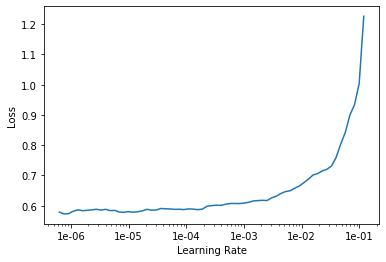

In [9]:
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(5, max_lr=3e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.594448,0.638757,0.168269,02:32
1,0.594029,0.651233,0.195513,02:34
2,0.541564,0.556844,0.125000,02:35
3,0.484766,0.552714,0.144231,02:32
4,0.440537,0.560659,0.149038,02:35


Better model found at epoch 0 with error_rate value: 0.16826923191547394.
Better model found at epoch 2 with error_rate value: 0.125.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


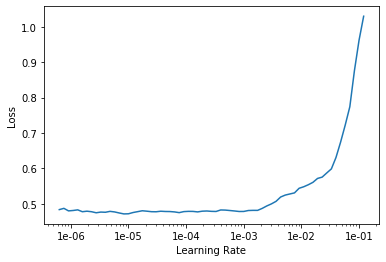

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(25, 1e-3, pct_start=0, final_div=1000)

epoch,train_loss,valid_loss,error_rate,time
0,0.614318,0.637735,0.149038,02:33
1,0.587554,0.531071,0.110577,02:34
2,0.576039,0.631367,0.173077,02:33
3,0.547488,0.649373,0.179487,02:34
4,0.527404,0.576326,0.139423,02:32
5,0.505837,0.633440,0.168269,02:33
6,0.481593,0.798140,0.235577,02:33
7,0.464558,0.701554,0.198718,02:32
8,0.433662,0.740819,0.193910,02:33
9,0.411939,0.704684,0.187500,02:34


Better model found at epoch 0 with error_rate value: 0.14903846383094788.
Better model found at epoch 1 with error_rate value: 0.11057692021131516.
